In [1]:
from pathlib import Path

import pandas as pd

PROJ_DIRECTORY = Path.cwd().parent / "matching_new"
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
#SUBM_DIRECTORY = PROJ_DIRECTORY / "submission"

metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv", index_col="image_id")
query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(viewpoint="top", random_state=1, metadata=metadata):
    # set plot layout depending on image viewpoint
    nrows, ncols = (1, 5) if viewpoint == "top" else (4, 2)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
    # get a random sample of images
    sample = metadata[metadata.viewpoint == viewpoint].sample(nrows*ncols, random_state=random_state)
    # plot in grid
    for img_path, ax in zip(sample.path, axes.flat):
        img = mpimg.imread(DATA_DIRECTORY / img_path)
        ax.imshow(img)    

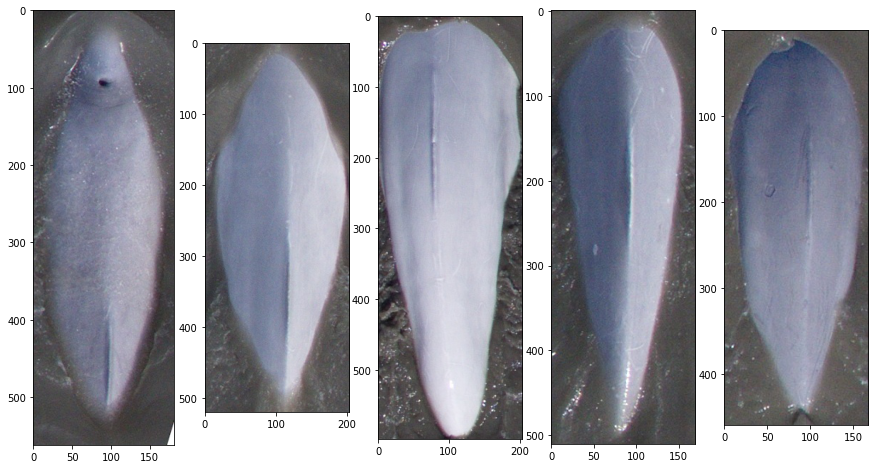

In [3]:
display_images("top", random_state=1)

In [4]:
metadata.viewpoint.value_counts()

top      5434
left      237
right     231
Name: viewpoint, dtype: int64

In [5]:
print(f"n images:    {len(metadata)}")
print(f"n whale IDs: {metadata.whale_id.nunique()}")

n images:    5902
n whale IDs: 788


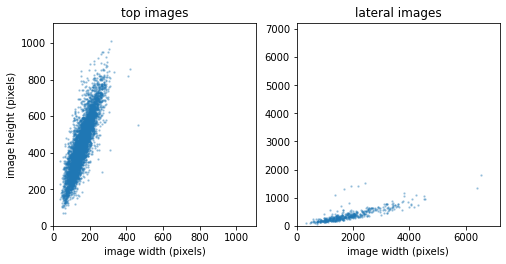

In [6]:
def plot_image_dims(metadata, ax, title=None, ylabel=True):
    lim = max(metadata.width.max(), metadata.height.max())*1.1    
    ax.scatter(metadata.width, metadata.height, s=2, alpha=0.3)
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    ax.set_xlabel('image width (pixels)')
    if ylabel:
        ax.set_ylabel('image height (pixels)')
    ax.set_aspect('equal')
    ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plot_image_dims(metadata[metadata.viewpoint == "top"], axes[0], title="top images")
plot_image_dims(metadata[metadata.viewpoint != "top"], axes[1], title="lateral images", ylabel=False)

1     155
2     161
3      89
4      57
5      41
6      53
7      27
8      25
9      11
10     16
dtype: int64


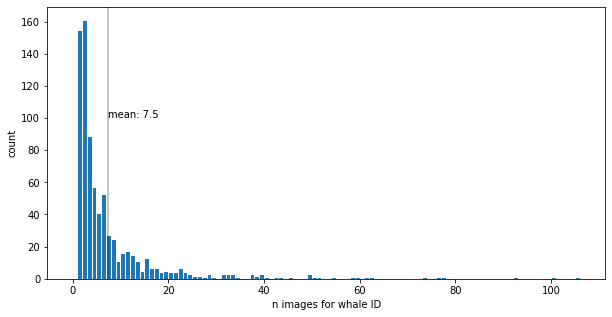

In [7]:
whale_id_counts = metadata.groupby("whale_id").size()

whale_id_counts.hist(bins=range(107), grid=False, figsize=(10,5), edgecolor="white")
plt.axvline(whale_id_counts.mean(), color='k', alpha=0.3)
plt.text(whale_id_counts.mean(), 100, s="mean: {:.1f}".format(whale_id_counts.mean()))
plt.xlabel("n images for whale ID")
plt.ylabel("count")

print(whale_id_counts.value_counts().sort_index().head(10))

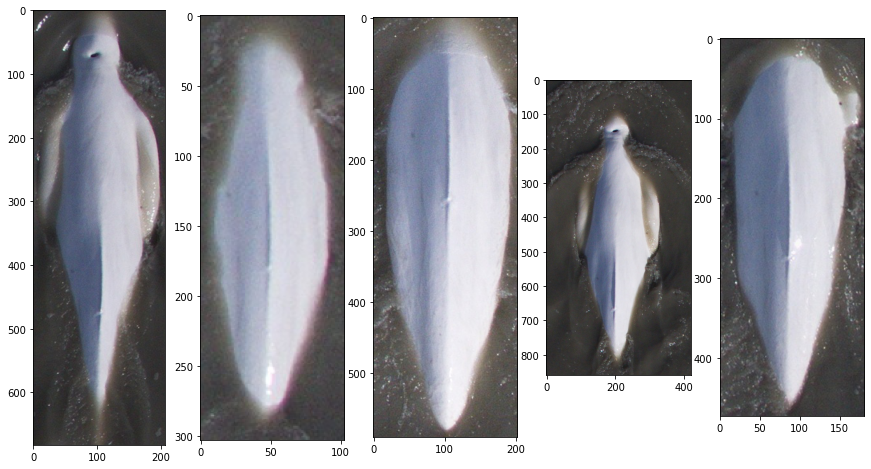

In [8]:
metadata_individual = metadata[metadata.whale_id == "whale093"]
display_images("top", metadata=metadata_individual, random_state=1)

In [9]:
metadata.head()

,path,height,width,viewpoint,date,timestamp,whale_id,encounter_id
image_id,,,,,,,,
train0000,images/train0000.jpg,463,150,top,2017-08-07,2017-08-07 20:38:36,whale000,whale000-000
train0001,images/train0001.jpg,192,81,top,2019-08-05,2019-08-05 16:49:13,whale001,whale001-000
train0002,images/train0002.jpg,625,183,top,2017-08-07,2017-08-07 22:12:19,whale002,whale002-000
train0003,images/train0003.jpg,673,237,top,2017-08-07,2017-08-07 20:40:59,whale003,whale003-000
train0004,images/train0004.jpg,461,166,top,2018-08-10,2018-08-10 21:45:30,whale004,whale004-000


In [10]:
import sys 
from tqdm import tqdm
import math
import random
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

In [11]:
class CFG:
    DIM = (512,512)
    NUM_WORKERS = 0
    TRAIN_BATCH_SIZE = 6
    VALID_BATCH_SIZE = 4
    EPOCHS = 20
    SEED = 42
    device = torch.device('cuda')
    model_name = 'tf_efficientnet_b2_ns'
    loss_module = 'arcface' #'cosface' #'adacos'
    s = 30.0
    m = 0.5 
    ls_eps = 0.0
    n_fold = 5
    easy_margin = False
    scheduler_params = {
          "lr_start": 1e-5,
          "lr_max": 1e-3 ,
          "lr_min": 1e-6,
          "lr_ramp_ep": 15,
          "lr_sus_ep": 0,
          "lr_decay": 0.8,
      }
    model_params = {
      'n_classes':788,
      'model_name':'tf_efficientnet_b5_ns',
      'use_fc':False,
      'fc_dim':2048,
      'dropout':0.0,
      'loss_module':loss_module,
      's':30.0,
      'margin':0.50,
      'ls_eps':0.0,
      'theta_zero':0.785,
      'pretrained':True
    }

In [12]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(CFG.SEED)

In [13]:
labels = set(metadata['whale_id'].values)
labels = list(labels)
labels = sorted(labels)
len(labels)
classes = []
for i in metadata['whale_id'].values:
    classes.append(labels.index(i))   
metadata["label"] = classes
len(labels)

788

In [14]:
#metadata = metadata[metadata["viewpoint"] == "top"]

In [15]:
metadata

,path,height,width,viewpoint,date,timestamp,whale_id,encounter_id,label
image_id,,,,,,,,,
train0000,images/train0000.jpg,463,150,top,2017-08-07,2017-08-07 20:38:36,whale000,whale000-000,0
train0001,images/train0001.jpg,192,81,top,2019-08-05,2019-08-05 16:49:13,whale001,whale001-000,1
train0002,images/train0002.jpg,625,183,top,2017-08-07,2017-08-07 22:12:19,whale002,whale002-000,2
train0003,images/train0003.jpg,673,237,top,2017-08-07,2017-08-07 20:40:59,whale003,whale003-000,3
train0004,images/train0004.jpg,461,166,top,2018-08-10,2018-08-10 21:45:30,whale004,whale004-000,4
...,...,...,...,...,...,...,...,...,...
train5897,images/train5897.jpg,242,92,top,2019-08-05,2019-08-05 16:25:59,whale355,whale355-001,355
train5898,images/train5898.jpg,441,143,top,2017-08-07,2017-08-07 20:36:37,whale206,whale206-000,206
train5899,images/train5899.jpg,434,144,top,2017-08-05,2017-08-05 20:44:14,whale658,whale658-001,658


In [16]:
literal = metadata[metadata["viewpoint"] != "top"]
top = metadata[metadata["viewpoint"] == "top"]
paths = []
for i in top.values:
    col = literal[literal["label"] == i[-1]]
    if len(col) != 0:
        col = col.sample(axis='rows')
        paths.append(col["path"].values[0])
    else:
        paths.append("N")
        

In [17]:
len(paths)

5434

In [18]:
top["path2"] = paths

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
metadata = top[top["path2"] != "N"]

In [20]:
metadata

,path,height,width,viewpoint,date,timestamp,whale_id,encounter_id,label,path2
image_id,,,,,,,,,,
train0002,images/train0002.jpg,625,183,top,2017-08-07,2017-08-07 22:12:19,whale002,whale002-000,2,images/train4509.jpg
train0003,images/train0003.jpg,673,237,top,2017-08-07,2017-08-07 20:40:59,whale003,whale003-000,3,images/train0842.jpg
train0008,images/train0008.jpg,165,73,top,2019-08-26,2019-08-26 11:48:32,whale008,whale008-000,8,images/train1279.jpg
train0009,images/train0009.jpg,455,163,top,2019-08-29,2019-08-29 13:50:31,whale009,whale009-000,9,images/train4909.jpg
train0010,images/train0010.jpg,589,189,top,2018-08-30,2018-08-30 00:24:41,whale010,whale010-000,10,images/train5066.jpg
...,...,...,...,...,...,...,...,...,...,...
train5892,images/train5892.jpg,429,191,top,2017-08-03,2017-08-03 18:26:33,whale183,whale183-001,183,images/train5072.jpg
train5895,images/train5895.jpg,365,95,top,2019-08-29,2019-08-29 13:20:20,whale082,whale082-000,82,images/train1571.jpg
train5896,images/train5896.jpg,558,267,top,2018-08-30,2018-08-30 00:53:15,whale010,whale010-000,10,images/train5156.jpg


In [21]:
folds = metadata.copy().reset_index()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.SEED)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['label'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

/home/tnn/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [22]:
folds

,image_id,path,height,width,viewpoint,date,timestamp,whale_id,encounter_id,label,path2,fold
0,train0002,images/train0002.jpg,625,183,top,2017-08-07,2017-08-07 22:12:19,whale002,whale002-000,2,images/train4509.jpg,0
1,train0003,images/train0003.jpg,673,237,top,2017-08-07,2017-08-07 20:40:59,whale003,whale003-000,3,images/train0842.jpg,1
2,train0008,images/train0008.jpg,165,73,top,2019-08-26,2019-08-26 11:48:32,whale008,whale008-000,8,images/train1279.jpg,3
3,train0009,images/train0009.jpg,455,163,top,2019-08-29,2019-08-29 13:50:31,whale009,whale009-000,9,images/train4909.jpg,0
4,train0010,images/train0010.jpg,589,189,top,2018-08-30,2018-08-30 00:24:41,whale010,whale010-000,10,images/train5066.jpg,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2484,train5892,images/train5892.jpg,429,191,top,2017-08-03,2017-08-03 18:26:33,whale183,whale183-001,183,images/train5072.jpg,4
2485,train5895,images/train5895.jpg,365,95,top,2019-08-29,2019-08-29 13:20:20,whale082,whale082-000,82,images/train1571.jpg,3
2486,train5896,images/train5896.jpg,558,267,top,2018-08-30,2018-08-30 00:53:15,whale010,whale010-000,10,images/train5156.jpg,3
2487,train5898,images/train5898.jpg,441,143,top,2017-08-07,2017-08-07 20:36:37,whale206,whale206-000,206,images/train3305.jpg,2


In [23]:
###########################################...............HELPERS...............#####
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def fetch_scheduler(optimizer):
        if CFG.SCHEDULER =='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True, eps=eps)
        elif CFG.SCHEDULER =='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=min_lr, last_epoch=-1)
        elif CFG.SCHEDULER =='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=1, eta_min=min_lr, last_epoch=-1)
        return scheduler

def fetch_loss():
    loss = nn.CrossEntropyLoss()
    return loss

In [24]:
def get_train_transforms():
    return albumentations.Compose(
        [   
            albumentations.Resize(CFG.DIM[0],CFG.DIM[1],always_apply=True),
            albumentations.HorizontalFlip(p=0.5),
            #albumentations.VerticalFlip(p=0.5),
            #albumentations.ImageCompression (quality_lower=50, quality_upper=100, p = 0.5),
            albumentations.OneOf([
            albumentations.Sharpen(p=0.3),
            albumentations.ToGray(p=0.3),
            albumentations.CLAHE(p=0.3),
            ], p=0.5),
            #albumentations.Rotate(limit=30, p=0.8),
            #albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.7),
            #albumentations.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.3),
            albumentations.ShiftScaleRotate(
               shift_limit=0.25, scale_limit=0.2, rotate_limit=4,p = 0.5
            ),
            albumentations.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            albumentations.Normalize(),
            ToTensorV2(),
        ]
    )

def get_valid_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(CFG.DIM[0],CFG.DIM[1],always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

In [25]:
class ToiletDataset(Dataset):
    def __init__(self, csv, transforms=None, transforms2 = None):

        self.csv = csv.reset_index()
        self.augmentations = transforms
        self.augmentations2 = transforms2

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread('data/' + row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image2 = cv2.imread('data/' + row.path2)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        if image2.shape[0] < image2.shape[1]:
            image2 = cv2.rotate(image2, cv2.ROTATE_90_CLOCKWISE)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image1 = augmented['image']
#         if self.augmentations2:
            augmented2 = self.augmentations(image=image2)                          
            image2 = augmented2['image']  
#             return image1,torch.tensor(row.label), image2
        
        return image1,image2,torch.tensor(row.label)

In [26]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [27]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
        nn.init.constant_(m.bias, 0.0)
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('BatchNorm') != -1:
        if m.affine:
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)


def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, std=0.001)
        if m.bias:
            nn.init.constant_(m.bias, 0.0)
            
class ToiletNet(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=True):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(ToiletNet, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  GeM()#nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(6144)
        self.ln = nn.Linear(6144, final_in_features)
        self.relu = nn.Hardtanh()
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.bn = nn.BatchNorm1d(fc_dim)
            self.bn.bias.requires_grad_(False)
            self.fc = nn.Linear(final_in_features, n_classes, bias = False)            
            self.bn.apply(weights_init_kaiming)
            self.fc.apply(weights_init_classifier)
            #self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ElasticArcFace(final_in_features, n_classes,
                                          s=s, m=margin)#, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, label):
        feature = self.extract_feat(x)
        if self.loss_module in ('arcface', 'cosface', 'adacos'):
            logits = self.final(feature, label)
        else:
            logits = self.final(feature)
        return logits, feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x1 = self.backbone.blocks[2]
        x2 = self.backbone.blocks[4]
        x1 = self.pooling(x).view(batch_size, -1)
        x2 = self.pooling(x).view(batch_size, -1)
        x3 = self.pooling(x).view(batch_size, -1)
        x = torch.cat((x1, x2, x3), dim=1)        
        #print(x.shape)
        x = self.bn(x)
        x = self.relu(x)
        x = self.ln(x)
        if self.use_fc:
            x1 = self.dropout(x)
            x1 = self.bn(x1)
            x1 = self.fc(x1)
            

        return x

In [28]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [29]:
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output
class ElasticArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50,std=0.0125,plus=False):
        super(ElasticArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)
        self.std=std
        self.plus=plus
    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1], device=cos_theta.device)
        margin = torch.normal(mean=self.m, std=self.std, size=label[index, None].size(), device=cos_theta.device) # Fast converge .clamp(self.m-self.std, self.m+self.std)
        if self.plus:
            with torch.no_grad():
                distmat = cos_theta[index, label.view(-1)].detach().clone()
                _, idicate_cosie = torch.sort(distmat, dim=0, descending=True)
                margin, _ = torch.sort(margin, dim=0)
            m_hot.scatter_(1, label[index, None], margin[idicate_cosie])
        else:
            m_hot.scatter_(1, label[index, None], margin)
        cos_theta.acos_()
        cos_theta[index] += m_hot
        cos_theta.cos_().mul_(self.s)
        return cos_theta

In [30]:
class ToiletScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ToiletScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [31]:
def train_fn(dataloader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    loss_score = AverageMeter()
    criterion2 = torch.nn.MSELoss()
    tk0 = tqdm(enumerate(dataloader), total=len(dataloader))
    for bi,d in tk0:
        
        batch_size = d[0].shape[0]


        images = d[0]
        targets = d[2]
        images2 = d[1]
        images = images.to(device)
        images2 = images2.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        output, feats1 = model(images,targets)
        output2, feats2 = model(images2,targets)
        
        loss = criterion(output,targets) + criterion(output2,targets) #+ criterion2(feats1,feats2) * 5
        
        loss.backward()
        optimizer.step()
        
        loss_score.update(loss.detach().item(), batch_size)
        tk0.set_postfix(Train_Loss=loss_score.avg,Epoch=epoch,LR=optimizer.param_groups[0]['lr'])
        
    if scheduler is not None:
            scheduler.step()
        
    return loss_score

In [32]:
def eval_fn(data_loader,model,criterion,device):
    loss_score = AverageMeter()
    loss_score1 = AverageMeter()
    loss_score2 = AverageMeter()
    
    model.eval()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    
    with torch.no_grad():
        
        for bi,d in tk0:
            batch_size = d[0].size()[0]

            image = d[0]
            image2 = d[1]
            targets = d[2]

            image = image.to(device)
            image2 = image2.to(device)
            targets = targets.to(device)

            output,_ = model(image,targets)
            output2,_ = model(image2,targets)
            
            loss1 = criterion(output,targets)
            loss2 = criterion(output2,targets)
            loss = (loss1 + loss2) / 2
            loss_score.update(loss.detach().item(), batch_size)
            loss_score1.update(loss1.detach().item(), batch_size)
            loss_score2.update(loss2.detach().item(), batch_size)
            tk0.set_postfix(Eval_Loss=loss_score.avg,Eval_Loss1=loss_score1.avg, Eval_loss2 = loss_score2.avg)
            
    return loss_score

In [33]:
def run(fold = 0):
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    train = folds.loc[trn_idx].reset_index(drop=True)
    valid = folds.loc[val_idx].reset_index(drop=True)
    # Defining DataSet
    train_dataset = ToiletDataset(
        csv=train,
        transforms=get_train_transforms(),
        transforms2=get_valid_transforms(),
    )
        
    valid_dataset = ToiletDataset(
        csv=valid,
        transforms=get_valid_transforms(),
    )
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CFG.TRAIN_BATCH_SIZE,
        pin_memory=True,
        drop_last=True,
        num_workers=CFG.NUM_WORKERS
    )
    
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=CFG.VALID_BATCH_SIZE,
        num_workers=CFG.NUM_WORKERS,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
    )
    
    # Defining Device
    device = torch.device("cuda")
    
    # Defining Model for specific fold
    model = ToiletNet(**CFG.model_params)
    model.to(device)
    
    #DEfining criterion
    criterion = fetch_loss()
    criterion.to(device)
        
    # Defining Optimizer with weight decay to params other than bias and layer norms
#     param_optimizer = list(model.named_parameters())
#     no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#     optimizer_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
#             ]  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.scheduler_params['lr_start'])
    
    #Defining LR SCheduler
    scheduler = ToiletScheduler(optimizer,**CFG.scheduler_params)
        
    # THE ENGINE LOOP
    best_loss = 10000
    for epoch in range(CFG.EPOCHS):
        train_loss = train_fn(train_loader, model,criterion, optimizer, device,scheduler=scheduler,epoch=epoch)
        
        valid_loss = eval_fn(valid_loader, model, criterion,device)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(),f'model_{CFG.model_name}_IMG_SIZE_{CFG.DIM[0]}_{CFG.loss_module}.bin')
            print('best model found for epoch {}'.format(epoch))

In [34]:
run(4)

Building Model Backbone for tf_efficientnet_b5_ns model


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 0


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 1


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 2


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 3


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 4


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 6


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 8


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 9


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 10


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 11


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 15


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 17


  0%|          | 0/332 [00:00<?, ?it/s]

best model found for epoch 18


 23%|██▎       | 29/125 [00:07<00:27,  3.50it/s, Eval_Loss=5.23, Eval_Loss1=8.23, Eval_loss2=2.22]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
6.76

In [ ]:
model = ToiletNet(**CFG.model_params)
# state = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface.bin",map_location=torch.device(CFG.device))
# model.load_state_dict(state)
# model.to(CFG.device)

In [ ]:
len(model.backbone.blocks)

In [ ]:
class ToiletNet_testing(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=True):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(ToiletNet_testing, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
            
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ArcMarginProduct(final_in_features, n_classes,
                                          s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature = self.extract_feat(x)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

In [ ]:
model = WhaleNet_testing(**CFG.model_params)
state = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface.bin",map_location=torch.device(CFG.device))
model.load_state_dict(state)
model.to(CFG.device)

In [ ]:
#%%writefile main.py
import sys 
from tqdm import tqdm
import math
import random
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics.pairwise import cosine_similarity

ROOT_DIRECTORY = Path("./")
PREDICTION_FILE = ROOT_DIRECTORY / "submission" / "submission.csv"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"

class CFG:
    DIM = (512,512)
    NUM_WORKERS = 0
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    EPOCHS = 20
    SEED = 42
    device = torch.device('cuda')
    model_name = 'tf_efficientnet_b2_ns'
    loss_module = 'arcface' #'cosface' #'adacos'
    s = 30.0
    m = 0.5 
    ls_eps = 0.0
    easy_margin = False
    scheduler_params = {
          "lr_start": 1e-5,
          "lr_max": 5e-4 ,
          "lr_min": 5e-6,
          "lr_ramp_ep": 15,
          "lr_sus_ep": 0,
          "lr_decay": 0.8,
      }
    model_params = {
      'n_classes':788,
      'model_name':'tf_efficientnet_b5_ns',
      'use_fc':False,
      'fc_dim':2048,
      'dropout':0.0,
      'loss_module':loss_module,
      's':30.0,
      'margin':0.50,
      'ls_eps':0.0,
      'theta_zero':0.785,
      'pretrained':False
    }


def get_valid_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(CFG.DIM[0],CFG.DIM[1],always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

class WhaleDataset_testing(Dataset):
    def __init__(self, csv, transforms=None):

        self.csv = csv
        self.augmentations = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread('data/' + row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
        
        
        return {"image_id": self.csv.index[index], "image": image}

    

def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output
class ElasticArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50,std=0.0125,plus=False):
        super(ElasticArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)
        self.std=std
        self.plus=plus
    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1], device=cos_theta.device)
        margin = torch.normal(mean=self.m, std=self.std, size=label[index, None].size(), device=cos_theta.device) # Fast converge .clamp(self.m-self.std, self.m+self.std)
        if self.plus:
            with torch.no_grad():
                distmat = cos_theta[index, label.view(-1)].detach().clone()
                _, idicate_cosie = torch.sort(distmat, dim=0, descending=True)
                margin, _ = torch.sort(margin, dim=0)
            m_hot.scatter_(1, label[index, None], margin[idicate_cosie])
        else:
            m_hot.scatter_(1, label[index, None], margin)
        cos_theta.acos_()
        cos_theta[index] += m_hot
        cos_theta.cos_().mul_(self.s)
        return cos_theta
    
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class WhaleNet_testing(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=False):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(WhaleNet_testing, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  GeM()#nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(6144)
        self.ln = nn.Linear(6144, final_in_features)
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ElasticArcFace(final_in_features, n_classes,
                                          s=s, m=margin)#, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature = self.extract_feat(x)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x1 = self.backbone.blocks[2]
        x2 = self.backbone.blocks[4]
        x1 = self.pooling(x).view(batch_size, -1)
        x2 = self.pooling(x).view(batch_size, -1)
        x3 = self.pooling(x).view(batch_size, -1)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.bn(x)
        x = self.ln(x)
        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

    
    
model = WhaleNet_testing(**CFG.model_params)
state = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f2_6-76.bin",map_location=torch.device(CFG.device))
model.load_state_dict(state)
model.to(CFG.device)


#logger.info("Starting main script")
# load test set data and pretrained model
query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")
metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv", index_col="image_id")
#logger.info("Loading pre-trained model")

# we'll only precompute embeddings for the images in the scenario files (rather than all images), so that the
# benchmark example can run quickly when doing local testing. this subsetting step is not necessary for an actual
# code submission since all the images in the test environment metadata also belong to a query or database.
scenario_imgs = []
for row in query_scenarios.itertuples():
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.queries_path).query_image_id.values)
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values)
scenario_imgs = sorted(set(scenario_imgs))
metadata = metadata.loc[scenario_imgs]

# instantiate dataset/loader and generate embeddings for all images
test_dataset = WhaleDataset_testing(metadata, transforms=get_valid_transforms())
dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)
embeddings = []
model.eval()

#logger.info("Precomputing embeddings")
for batch in tqdm(dataloader, total=len(dataloader)):
    batch_embeddings = model(batch["image"].to(CFG.device))
    
    batch_embeddings = batch_embeddings.detach().cpu().numpy()
    

    batch_embeddings_df = pd.DataFrame(batch_embeddings, index=batch["image_id"])
    embeddings.append(batch_embeddings_df)

embeddings = pd.concat(embeddings)
#logger.info(f"Precomputed embeddings for {len(embeddings)} images")

#logger.info("Generating image rankings")
# process all scenarios
results = []
for row in query_scenarios.itertuples():
    # load query df and database images; subset embeddings to this scenario's database
    qry_df = pd.read_csv(DATA_DIRECTORY / row.queries_path)
    db_img_ids = pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values
    db_embeddings = embeddings.loc[db_img_ids]
    metd = metadata.loc[db_img_ids]
    if all(i == "top" for i in metd["viewpoint"].values):
        print("hi")
    # predict matches for each query in this scenario
    for qry in qry_df.itertuples():
        # get embeddings; drop query from database, if it exists
        qry_embedding = embeddings.loc[[qry.query_image_id]]
        _db_embeddings = db_embeddings.drop(qry.query_image_id, errors='ignore')

        # compute cosine similarities and get top 20
        sims = cosine_similarity(qry_embedding, _db_embeddings)[0]
        top20 = pd.Series(sims, index=_db_embeddings.index).sort_values(0, ascending=False).head(20)

        # append result
        qry_result = pd.DataFrame(
            {"query_id": qry.query_id, "database_image_id": top20.index, "score": top20.values}
        )
        results.append(qry_result)

#logger.info(f"Writing predictions file to {PREDICTION_FILE}")
submission = pd.concat(results)
submission.to_csv(PREDICTION_FILE, index=False)

In [ ]:
#%%writefile main.py
import sys 
from tqdm import tqdm
import math
import random
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics.pairwise import cosine_similarity

ROOT_DIRECTORY = Path("./")
PREDICTION_FILE = ROOT_DIRECTORY / "submission" / "submission.csv"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"

class CFG:
    DIM = (512,512)
    NUM_WORKERS = 0
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    EPOCHS = 20
    SEED = 42
    device = torch.device('cuda')
    model_name = 'tf_efficientnet_b2_ns'
    loss_module = 'arcface' #'cosface' #'adacos'
    s = 30.0
    m = 0.5 
    ls_eps = 0.0
    easy_margin = False
    scheduler_params = {
          "lr_start": 1e-5,
          "lr_max": 5e-4 ,
          "lr_min": 5e-6,
          "lr_ramp_ep": 15,
          "lr_sus_ep": 0,
          "lr_decay": 0.8,
      }
    model_params = {
      'n_classes':788,
      'model_name':'tf_efficientnet_b5_ns',
      'use_fc':False,
      'fc_dim':2048,
      'dropout':0.0,
      'loss_module':loss_module,
      's':30.0,
      'margin':0.50,
      'ls_eps':0.0,
      'theta_zero':0.785,
      'pretrained':False
    }


def get_valid_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(CFG.DIM[0],CFG.DIM[1],always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

class WhaleDataset_testing(Dataset):
    def __init__(self, csv, transforms=None):

        self.csv = csv
        self.augmentations = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread('data/' + row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
        
        
        return {"image_id": self.csv.index[index], "image": image}

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class WhaleNet_testing(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=False):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(WhaleNet_testing, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
        self.ln = nn.Linear(6144, final_in_features)
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ArcMarginProduct(final_in_features, n_classes,
                                          s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature = self.extract_feat(x)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x1 = self.backbone.blocks[2]
        x2 = self.backbone.blocks[4]
        x1 = self.pooling(x).view(batch_size, -1)
        x2 = self.pooling(x).view(batch_size, -1)
        x3 = self.pooling(x).view(batch_size, -1)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.ln(x)
        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

    
    
model = WhaleNet_testing(**CFG.model_params)
state = torch.load("model_tf_efficientnet_b4_ns_IMG_SIZE_512_arcface_f0_8-15.bin",map_location=torch.device(CFG.device))
model.load_state_dict(state)
model.to(CFG.device)

model2 = WhaleNet_testing(**CFG.model_params)
state2 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f1_8-66.bin",map_location=torch.device(CFG.device))
model2.load_state_dict(state)
model2.to(CFG.device)

#logger.info("Starting main script")
# load test set data and pretrained model
query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")
metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv", index_col="image_id")
#logger.info("Loading pre-trained model")

# we'll only precompute embeddings for the images in the scenario files (rather than all images), so that the
# benchmark example can run quickly when doing local testing. this subsetting step is not necessary for an actual
# code submission since all the images in the test environment metadata also belong to a query or database.
scenario_imgs = []
for row in query_scenarios.itertuples():
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.queries_path).query_image_id.values)
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values)
scenario_imgs = sorted(set(scenario_imgs))
metadata = metadata.loc[scenario_imgs]

# instantiate dataset/loader and generate embeddings for all images
test_dataset = WhaleDataset_testing(metadata, transforms=get_valid_transforms())
dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)
embeddings = []
model.eval()
model2.eval()

#logger.info("Precomputing embeddings")
for batch in tqdm(dataloader, total=len(dataloader)):
    batch_embeddings = model(batch["image"].to(CFG.device))
    batch_embeddings2 = model2(batch["image"].to(CFG.device))
    batch_embeddings = batch_embeddings.detach().cpu().numpy()
    batch_embeddings2 = batch_embeddings2.detach().cpu().numpy()
    batch_embeddings = np.concatenate((batch_embeddings, batch_embeddings2), 1)
    batch_embeddings_df = pd.DataFrame(batch_embeddings, index=batch["image_id"])
    embeddings.append(batch_embeddings_df)

embeddings = pd.concat(embeddings)
#logger.info(f"Precomputed embeddings for {len(embeddings)} images")

#logger.info("Generating image rankings")
# process all scenarios
results = []
for row in query_scenarios.itertuples():
    # load query df and database images; subset embeddings to this scenario's database
    qry_df = pd.read_csv(DATA_DIRECTORY / row.queries_path)
    db_img_ids = pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values
    db_embeddings = embeddings.loc[db_img_ids]
    metd = metadata.loc[db_img_ids]
    if all(i == "top" for i in metd["viewpoint"].values):
        print("hi")
    # predict matches for each query in this scenario
    for qry in qry_df.itertuples():
        # get embeddings; drop query from database, if it exists
        qry_embedding = embeddings.loc[[qry.query_image_id]]
        _db_embeddings = db_embeddings.drop(qry.query_image_id, errors='ignore')

        # compute cosine similarities and get top 20
        sims = cosine_similarity(qry_embedding, _db_embeddings)[0]
        top20 = pd.Series(sims, index=_db_embeddings.index).sort_values(0, ascending=False).head(20)

        # append result
        qry_result = pd.DataFrame(
            {"query_id": qry.query_id, "database_image_id": top20.index, "score": top20.values}
        )
        results.append(qry_result)

#logger.info(f"Writing predictions file to {PREDICTION_FILE}")
submission = pd.concat(results)
submission.to_csv(PREDICTION_FILE, index=False)

In [ ]:
df = submission

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
df = pd.read_csv("submission.csv")

In [ ]:
for idx, i in enumerate(df.values):
    print("<<<<<<<<< startmatching >>>>>>>>>>>>>>>>")
    path1 = i[0].split("-")[-1]
    path2 = i[1]
    path1 = "data/images/" + path1 + ".jpg"
    path2 = "data/images/" + path2 + ".jpg"
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    if idx % 20 == 0:
        plt.imshow(img1)
        plt.show()
        plt.imshow(img2)
        plt.show()
        print("<<<<<<<<< end >>>>>>>>>>>>>>>>")